In [0]:
import gym

import os
import random

from collections import deque

from skimage import io, color, transform

import numpy as np

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import torchvision


%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
env = gym.make("MsPacman-v0")

In [45]:
NUM_EPISODES = 80000000

EPSILON = 1
EPSILON_DECAY = 1-5e-5

GAMMA = 0.9
ALPHA = 0.95
ALPHA_DECAY = 1

EXPERIENCE_REPLAY_CAPACITY = 10000
MINIBATCH_SIZE = 100
LEARNING_RATE = 0.001
ACTION_SIZE = env.action_space.n

IMAGE_DIM = 84

MODEL_SAVE_PATH = F"/content/gdrive/My Drive/MsPacmanDQN.pkl" 

print(ACTION_SIZE)

9


In [0]:
def preprocess_observation(observation):
    """
    Helper function for preprocessing an observation for consumption by our
    deep learning network
    """
    grayscale_observation = color.rgb2gray(observation)
    resized_observation = transform.resize(grayscale_observation, (IMAGE_DIM, IMAGE_DIM))
    return torch.Tensor(resized_observation)

In [0]:
def get_state(dq):
    state = torch.stack(list(dq), dim=0)

    return state

In [0]:
class Flatten(nn.Module):
    def forward(self, x):
        N = x.size(0)
        return x.view(N, -1)

class DQN(nn.Module):
    def __init__(self):
        # Map input_dim (last 4 frames of the game) to Q scores of all actions
        # in that state
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=(8, 8), padding=(0, 0), stride=(4, 4)),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=(4, 4), padding=(0, 0), stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(0, 0)),
            nn.ReLU(inplace=True),
            Flatten(),
            nn.Linear(3136, 512), nn.ReLU(),
            nn.Linear(512, 9)
        )

    def forward(self, x):
        return self.model(x)

In [0]:
class Agent:
    def __init__(self, epsilon, epsilon_decay, alpha, alpha_decay,
                       gamma, minibatch_size, learning_rate):
        self.dqn = DQN().cuda()
        self.target_dqn = DQN().cuda()
        self.target_dqn.load_state_dict(self.dqn.state_dict())

        self.alpha = alpha
        self.alpha_decay = alpha_decay
        self.gamma = gamma

        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay

        self.minibatch_size = minibatch_size
        self.minibatch_range = np.arange(minibatch_size)

        self.optimizer = torch.optim.Adam(self.dqn.parameters(),
                                          lr=learning_rate)

    def get_action(self, state, exploit=False):
        if np.random.uniform() < self.epsilon and not exploit:
            return env.action_space.sample()
        else:
            q_vals = self.target_dqn(state.unsqueeze(0).cuda())
            return torch.argmax(q_vals).item()

    def train(self, replay_memory):
        # Sample a minibatch from replay_memoy
        # Now unpack the state, action, reward values and calculate the
        # better_q approximation

        sample = random.sample(replay_memory, self.minibatch_size)

        alpha = self.alpha
        gamma = self.gamma

        # Unpack data from replay_memory
        states = torch.stack([x[0] for x in sample])
        rewards = torch.cuda.FloatTensor([x[2] for x in sample])
        actions = [x[1] for x in sample]
        next_states = torch.stack([x[-1] for x in sample])

        # Calculate all required Variables for equation
        prev_qs = agent.dqn(states.cuda())[self.minibatch_range, actions]
        next_qs = agent.target_dqn(next_states.cuda())
        max_next_qs, _ = torch.max(next_qs, 1)

        # Calculate loss
        better_q = (1-alpha)*prev_qs + alpha*(rewards + gamma*max_next_qs)
        loss = ((better_q - prev_qs)**2).sum()

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Slow down learning
        self.alpha *= self.alpha_decay

    def load_from_path(self, path):
        self.dqn.load_state_dict(torch.load(path))
        self.update_target_network()

    def update_target_network(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())
        self.epsilon *= self.epsilon_decay


agent = Agent(epsilon=EPSILON, epsilon_decay=EPSILON_DECAY,
              alpha=ALPHA, alpha_decay=ALPHA_DECAY, gamma=GAMMA,
              minibatch_size=MINIBATCH_SIZE, learning_rate=LEARNING_RATE)

agent.load_from_path(MODEL_SAVE_PATH)

Episode number 0
Ended frame 150 with cumulative reward 60.0


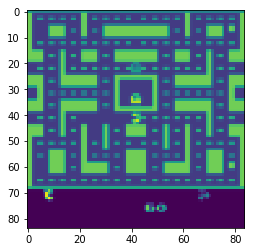

Ended frame 300 with cumulative reward 70.0


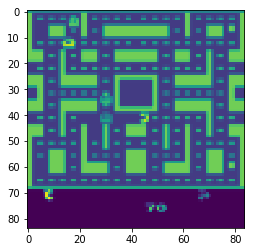

Ended frame 450 with cumulative reward 90.0


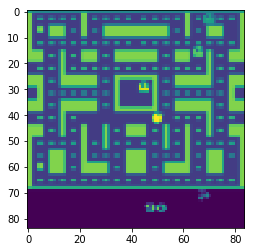

Ended frame 600 with cumulative reward 190.0


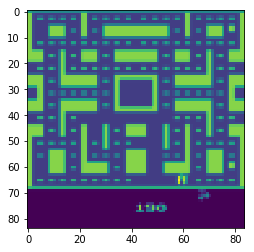

Ended frame 605 with cumulative reward 190.0


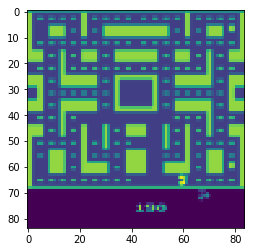

Episode number 1
Ended frame 150 with cumulative reward 20.0


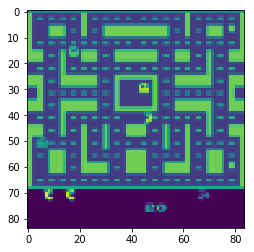

Ended frame 300 with cumulative reward 80.0


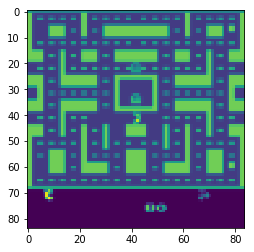

Ended frame 450 with cumulative reward 100.0


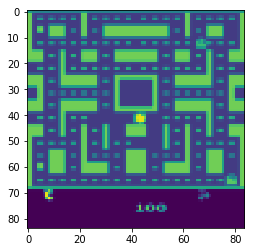

Ended frame 600 with cumulative reward 100.0


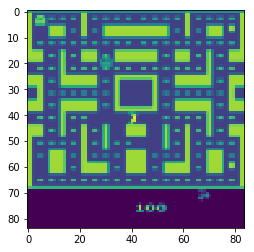

Ended frame 660 with cumulative reward 100.0


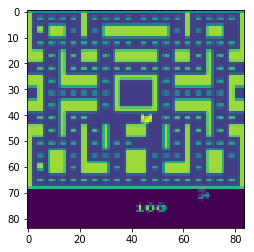

Episode number 2
Ended frame 150 with cumulative reward 70.0


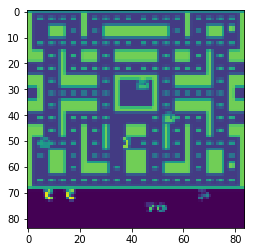

Ended frame 300 with cumulative reward 100.0


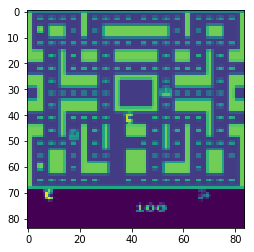

Ended frame 450 with cumulative reward 100.0


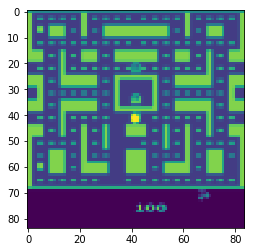

Ended frame 600 with cumulative reward 140.0


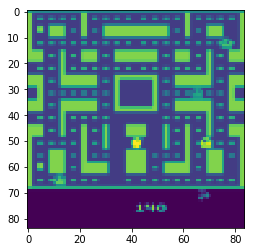

Ended frame 649 with cumulative reward 140.0


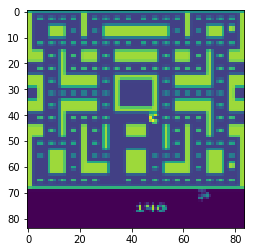

Episode number 3
Ended frame 150 with cumulative reward 50.0


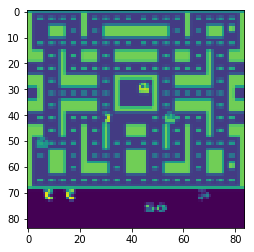

Ended frame 300 with cumulative reward 170.0


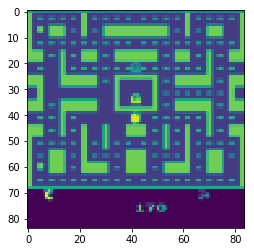

Ended frame 450 with cumulative reward 240.0


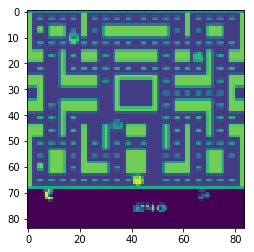

Ended frame 600 with cumulative reward 240.0


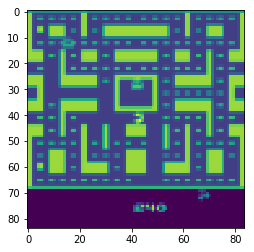

Ended frame 735 with cumulative reward 310.0


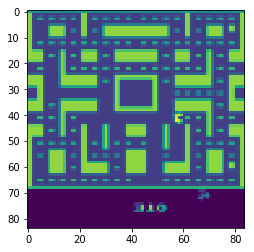

Episode number 4
Ended frame 150 with cumulative reward 70.0


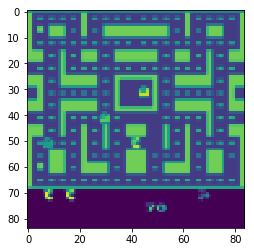

Ended frame 300 with cumulative reward 110.0


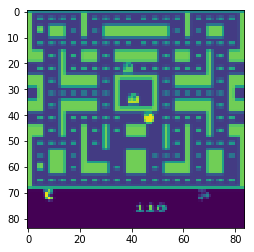

Ended frame 450 with cumulative reward 200.0


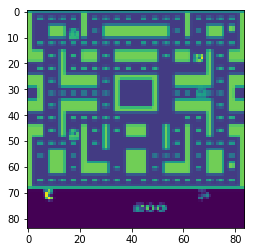

Ended frame 568 with cumulative reward 230.0


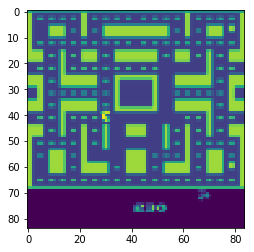

Episode number 5
Ended frame 150 with cumulative reward 70.0


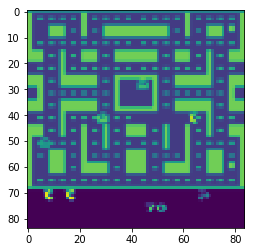

Ended frame 300 with cumulative reward 150.0


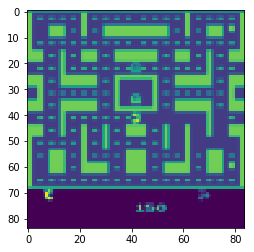

Ended frame 450 with cumulative reward 210.0


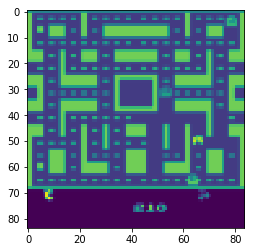

Ended frame 600 with cumulative reward 280.0


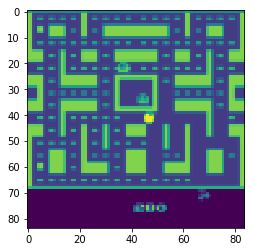

Ended frame 743 with cumulative reward 320.0


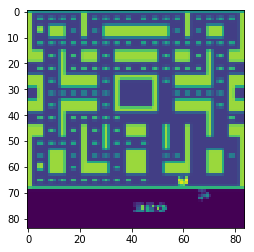

Episode number 6
Ended frame 150 with cumulative reward 50.0


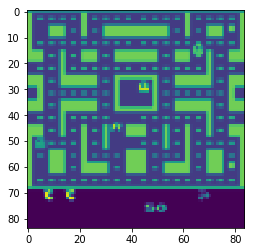

Ended frame 300 with cumulative reward 70.0


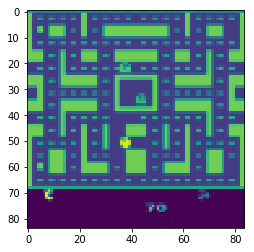

Ended frame 450 with cumulative reward 120.0


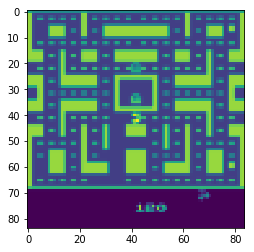

Ended frame 531 with cumulative reward 150.0


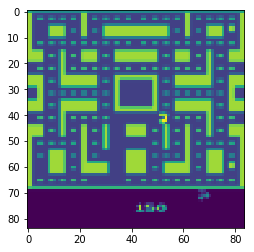

Episode number 7
Ended frame 150 with cumulative reward 50.0


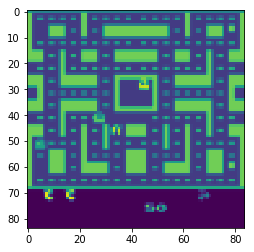

Ended frame 300 with cumulative reward 140.0


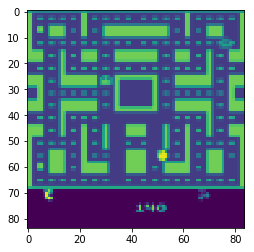

Ended frame 450 with cumulative reward 200.0


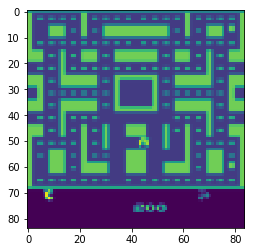

Ended frame 600 with cumulative reward 270.0


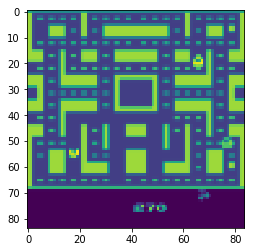

Ended frame 750 with cumulative reward 290.0


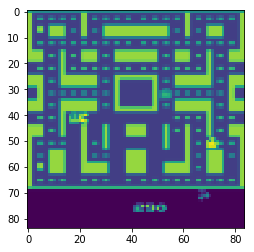

Ended frame 771 with cumulative reward 290.0


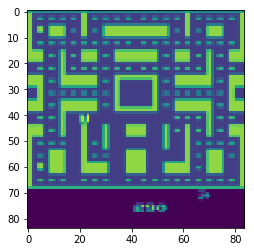

Episode number 8
Ended frame 150 with cumulative reward 60.0


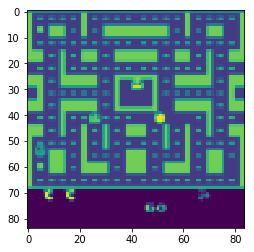

Ended frame 300 with cumulative reward 150.0


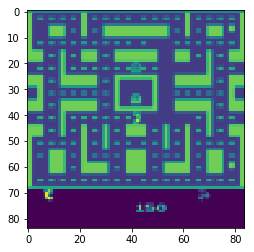

Ended frame 450 with cumulative reward 250.0


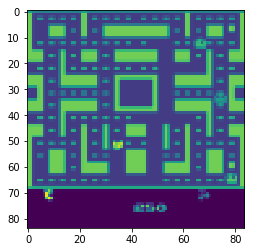

Ended frame 600 with cumulative reward 270.0


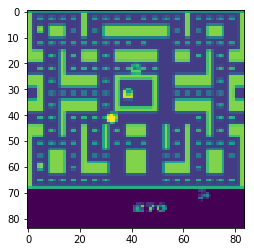

Ended frame 655 with cumulative reward 290.0


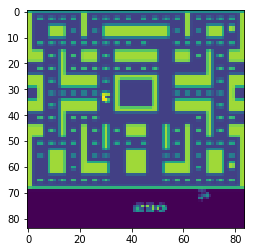

Episode number 9
Ended frame 150 with cumulative reward 80.0


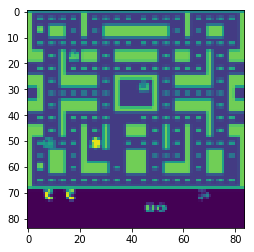

Ended frame 300 with cumulative reward 140.0


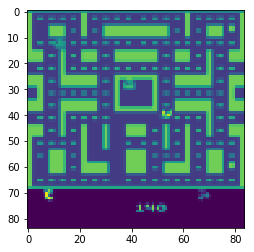

Ended frame 450 with cumulative reward 180.0


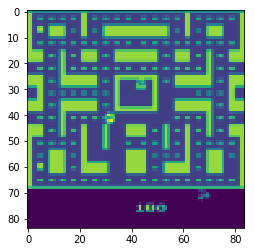

Ended frame 496 with cumulative reward 230.0


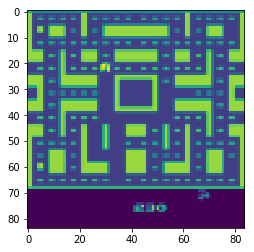

Episode number 10
Ended frame 150 with cumulative reward 30.0


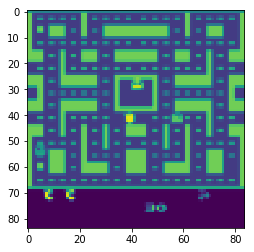

Ended frame 300 with cumulative reward 110.0


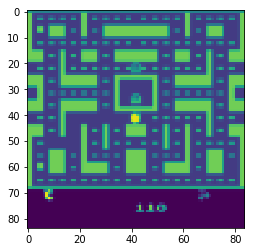

Ended frame 450 with cumulative reward 140.0


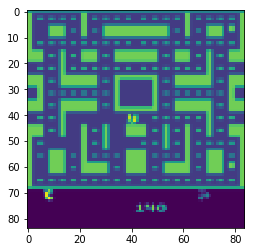

Ended frame 600 with cumulative reward 230.0


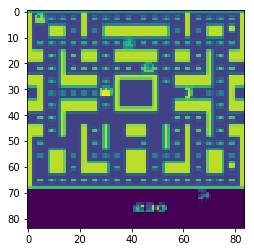

Ended frame 650 with cumulative reward 250.0


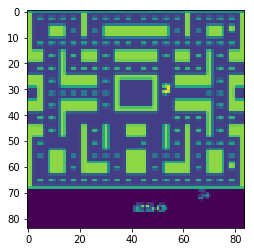

Episode number 11
Ended frame 150 with cumulative reward 40.0


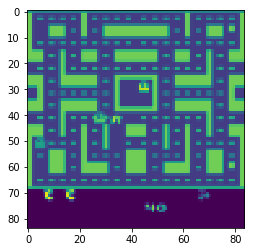

Ended frame 300 with cumulative reward 90.0


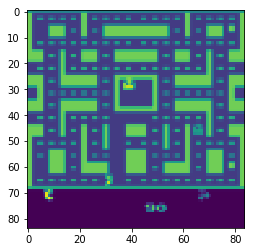

Ended frame 450 with cumulative reward 150.0


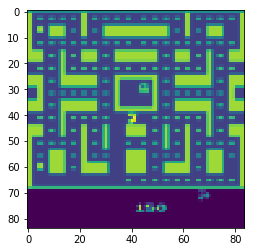

Ended frame 511 with cumulative reward 180.0


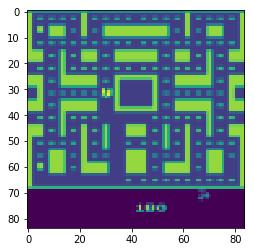

Episode number 12
Ended frame 150 with cumulative reward 40.0


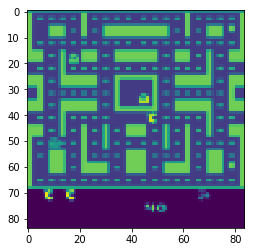

Ended frame 300 with cumulative reward 40.0


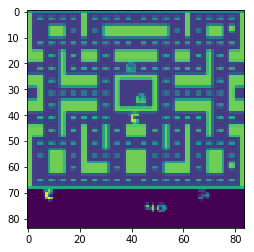

Ended frame 450 with cumulative reward 190.0


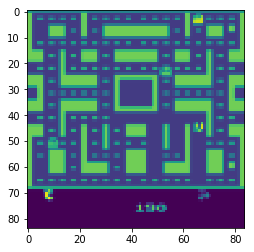

Ended frame 600 with cumulative reward 220.0


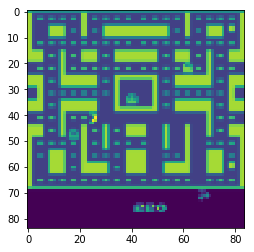

Ended frame 704 with cumulative reward 260.0


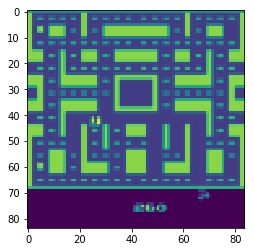

Episode number 13
Ended frame 150 with cumulative reward 30.0


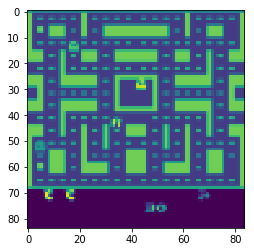

Ended frame 300 with cumulative reward 70.0


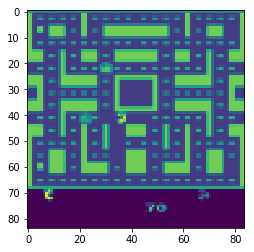

Ended frame 450 with cumulative reward 110.0


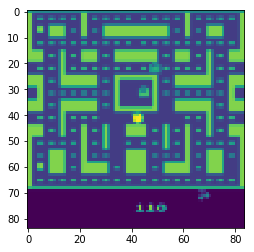

Ended frame 600 with cumulative reward 170.0


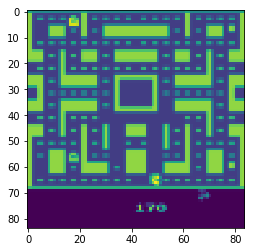

Ended frame 619 with cumulative reward 170.0


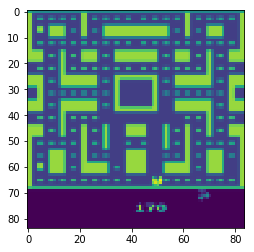

Episode number 14
Ended frame 150 with cumulative reward 40.0


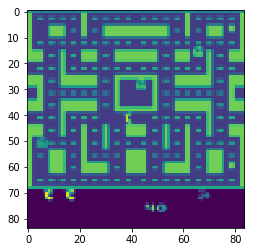

Ended frame 300 with cumulative reward 90.0


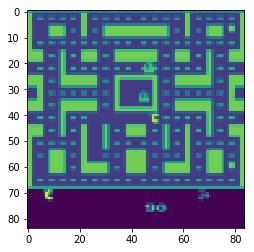

Ended frame 450 with cumulative reward 180.0


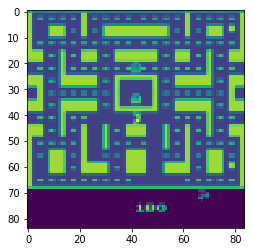

Ended frame 600 with cumulative reward 190.0


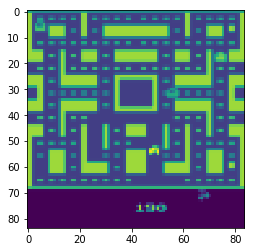

Ended frame 673 with cumulative reward 240.0


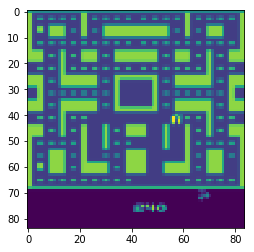

Episode number 15
Ended frame 150 with cumulative reward 40.0


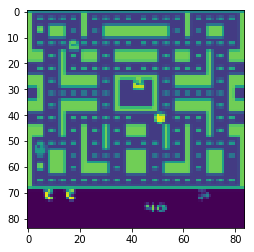

Ended frame 300 with cumulative reward 260.0


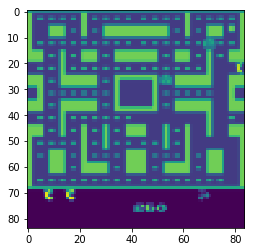

Ended frame 450 with cumulative reward 370.0


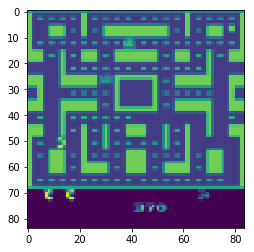

Ended frame 600 with cumulative reward 420.0


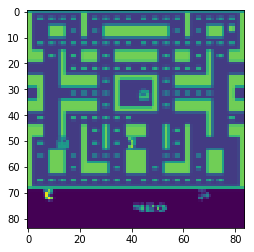

Ended frame 750 with cumulative reward 490.0


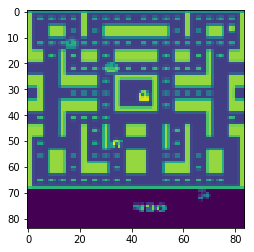

Ended frame 893 with cumulative reward 550.0


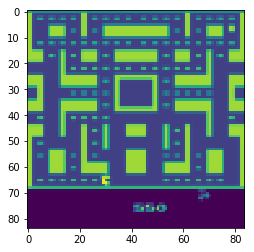

Episode number 16
Ended frame 150 with cumulative reward 30.0


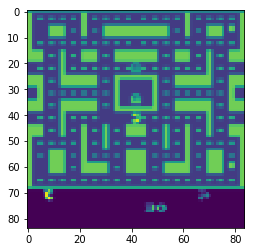

Ended frame 300 with cumulative reward 60.0


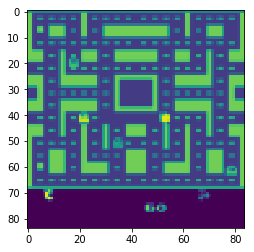

Ended frame 450 with cumulative reward 100.0


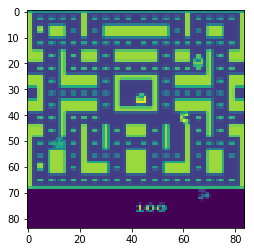

Ended frame 578 with cumulative reward 120.0


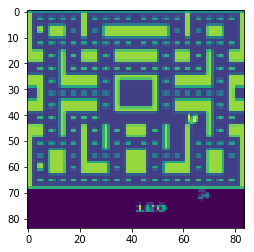

Episode number 17
Ended frame 150 with cumulative reward 40.0


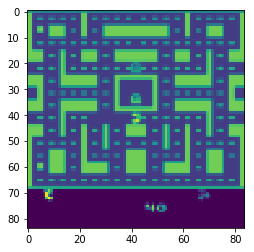

Ended frame 300 with cumulative reward 90.0


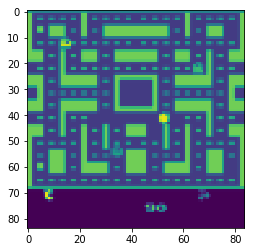

Ended frame 450 with cumulative reward 110.0


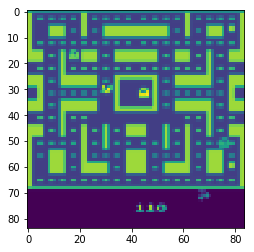

Ended frame 496 with cumulative reward 140.0


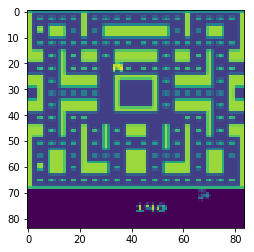

Episode number 18
Ended frame 150 with cumulative reward 70.0


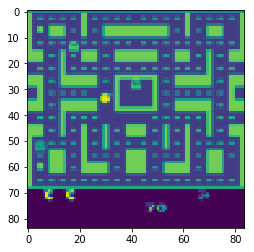

Ended frame 300 with cumulative reward 110.0


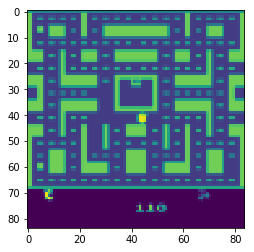

Ended frame 450 with cumulative reward 170.0


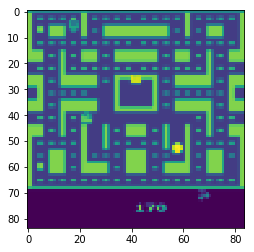

Ended frame 530 with cumulative reward 170.0


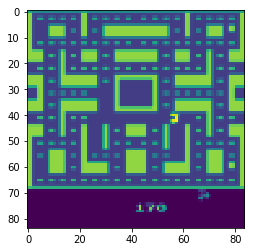

Episode number 19
Ended frame 150 with cumulative reward 30.0


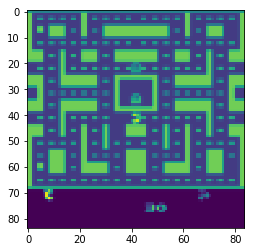

Ended frame 300 with cumulative reward 50.0


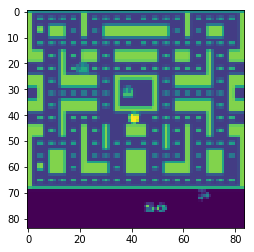

Ended frame 427 with cumulative reward 120.0


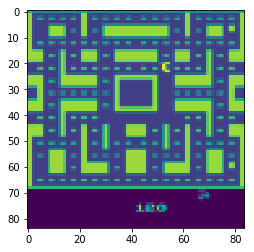

Episode number 20
Ended frame 150 with cumulative reward 40.0


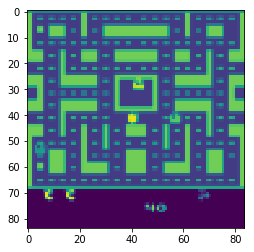

Ended frame 300 with cumulative reward 130.0


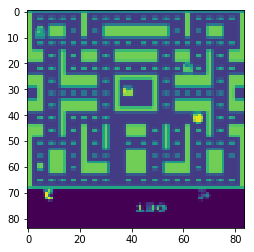

Ended frame 450 with cumulative reward 210.0


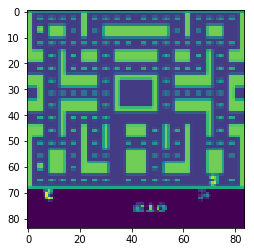

Ended frame 600 with cumulative reward 210.0


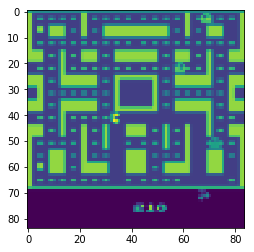

Ended frame 672 with cumulative reward 230.0


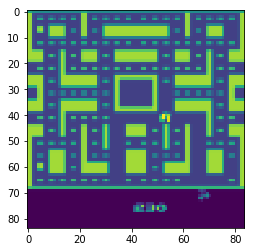

Episode number 21
Ended frame 150 with cumulative reward 50.0


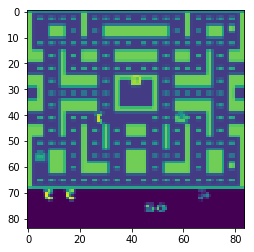

Ended frame 300 with cumulative reward 240.0


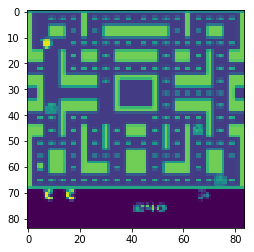

Ended frame 450 with cumulative reward 300.0


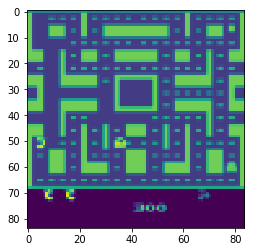

Ended frame 600 with cumulative reward 380.0


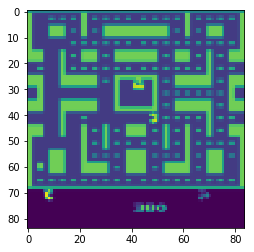

Ended frame 750 with cumulative reward 520.0


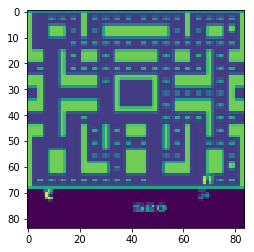

Ended frame 900 with cumulative reward 540.0


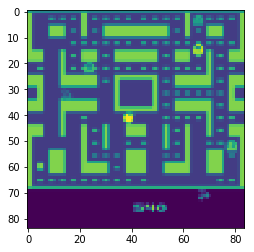

Ended frame 988 with cumulative reward 540.0


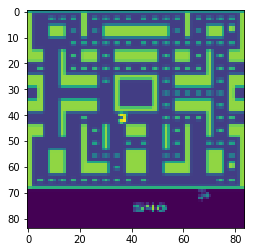

Episode number 22
Ended frame 150 with cumulative reward 40.0


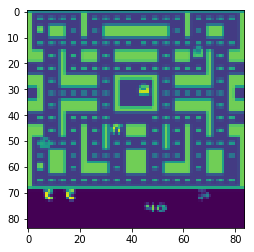

Ended frame 300 with cumulative reward 90.0


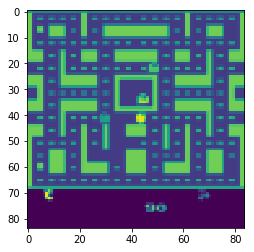

Ended frame 450 with cumulative reward 130.0


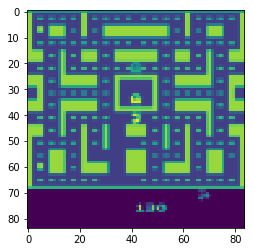

Ended frame 600 with cumulative reward 140.0


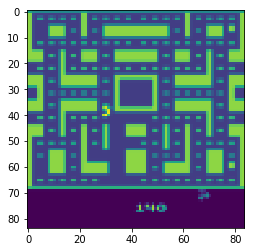

Ended frame 606 with cumulative reward 140.0


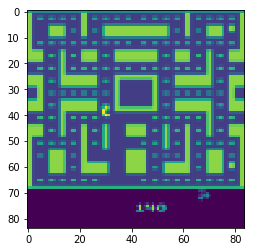

Episode number 23
Ended frame 150 with cumulative reward 100.0


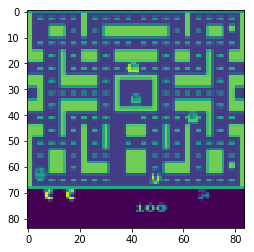

Ended frame 300 with cumulative reward 170.0


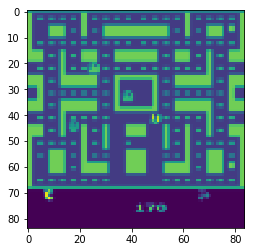

Ended frame 450 with cumulative reward 170.0


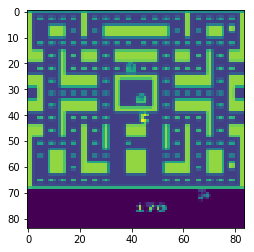

Ended frame 578 with cumulative reward 230.0


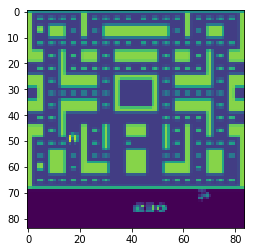

Episode number 24
Ended frame 150 with cumulative reward 60.0


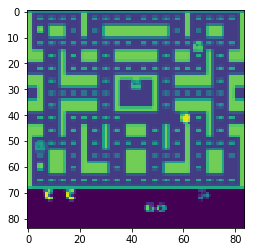

Ended frame 300 with cumulative reward 60.0


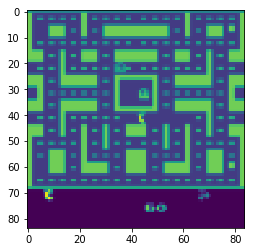

Ended frame 450 with cumulative reward 80.0


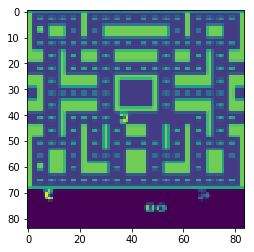

Ended frame 600 with cumulative reward 110.0


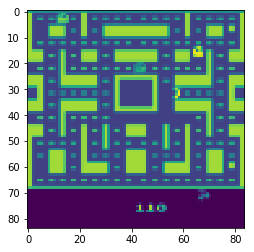

Ended frame 646 with cumulative reward 120.0


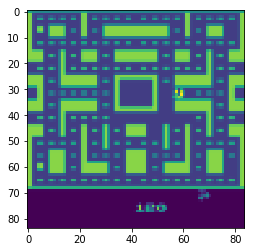

Episode number 25
Ended frame 150 with cumulative reward 70.0


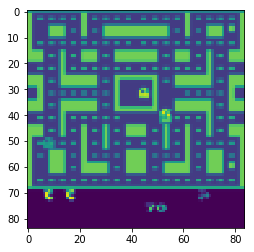

Ended frame 300 with cumulative reward 100.0


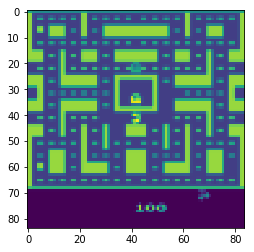

Ended frame 450 with cumulative reward 120.0


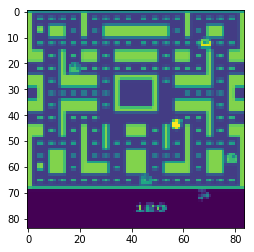

Ended frame 514 with cumulative reward 150.0


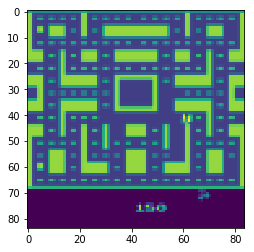

Episode number 26
Ended frame 150 with cumulative reward 50.0


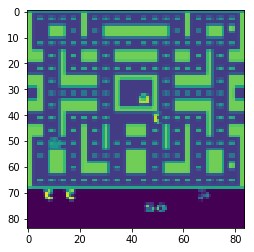

Ended frame 300 with cumulative reward 70.0


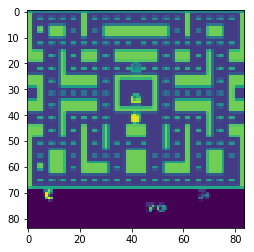

Ended frame 450 with cumulative reward 90.0


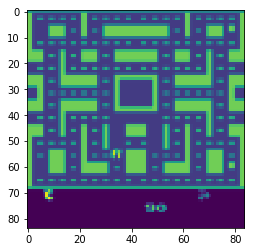

Ended frame 600 with cumulative reward 130.0


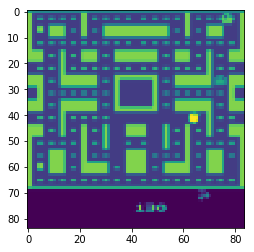

Ended frame 668 with cumulative reward 130.0


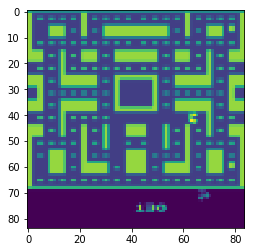

Episode number 27
Ended frame 150 with cumulative reward 40.0


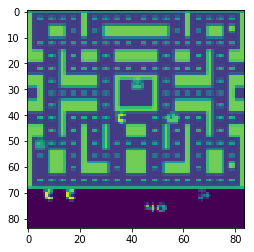

Ended frame 300 with cumulative reward 40.0


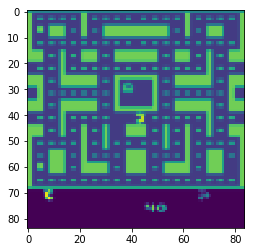

Ended frame 450 with cumulative reward 130.0


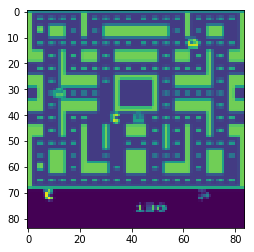

Ended frame 600 with cumulative reward 180.0


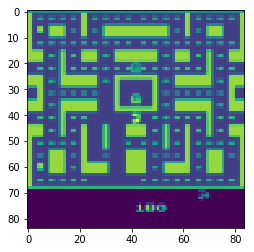

Ended frame 750 with cumulative reward 190.0


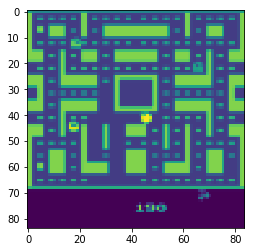

Ended frame 817 with cumulative reward 230.0


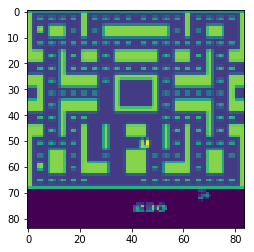

Episode number 28
Ended frame 150 with cumulative reward 30.0


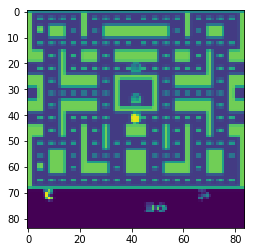

Ended frame 300 with cumulative reward 80.0


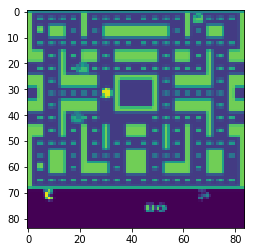

Ended frame 450 with cumulative reward 120.0


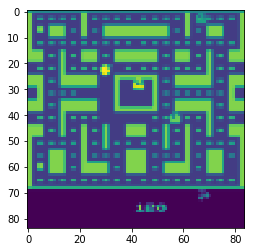

Ended frame 600 with cumulative reward 190.0


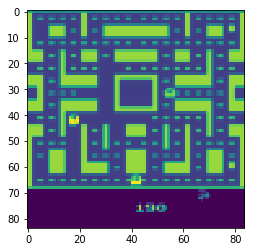

Ended frame 617 with cumulative reward 190.0


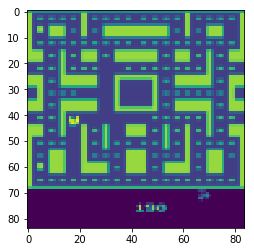

Episode number 29
Ended frame 150 with cumulative reward 40.0


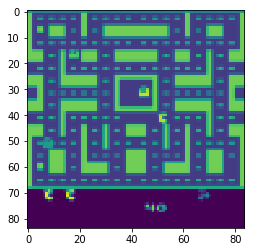

Ended frame 300 with cumulative reward 100.0


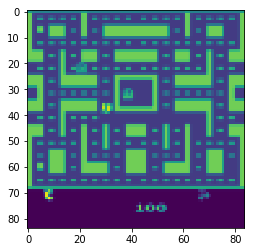

Ended frame 450 with cumulative reward 190.0


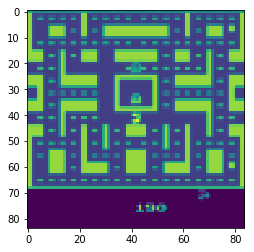

Ended frame 591 with cumulative reward 220.0


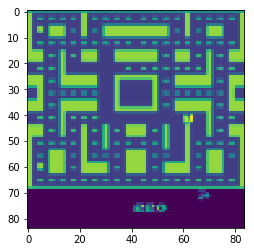

Episode number 30
Ended frame 150 with cumulative reward 60.0


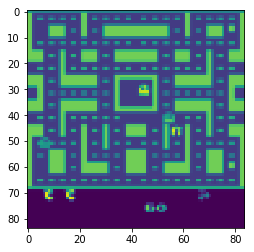

Ended frame 300 with cumulative reward 150.0


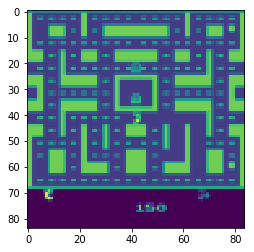

Ended frame 450 with cumulative reward 240.0


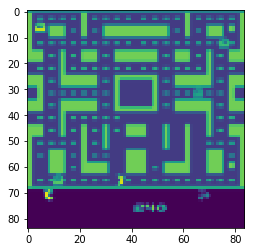

Ended frame 600 with cumulative reward 280.0


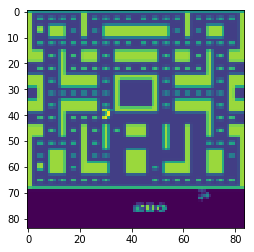

Ended frame 606 with cumulative reward 280.0


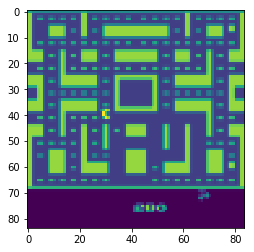

Episode number 31
Ended frame 150 with cumulative reward 50.0


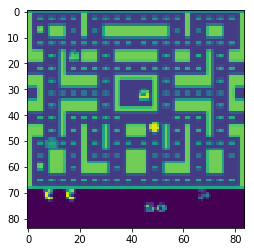

Ended frame 300 with cumulative reward 110.0


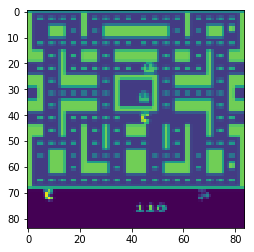

Ended frame 450 with cumulative reward 130.0


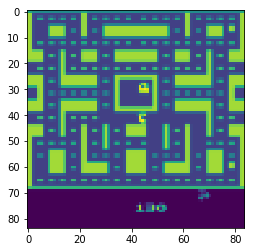

Ended frame 575 with cumulative reward 210.0


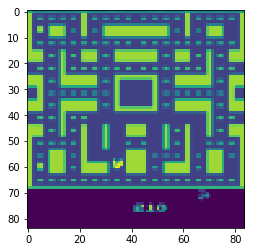

Episode number 32
Ended frame 150 with cumulative reward 60.0


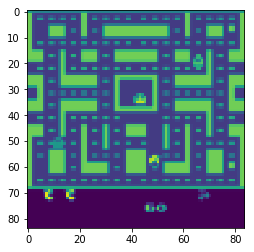

Ended frame 300 with cumulative reward 160.0


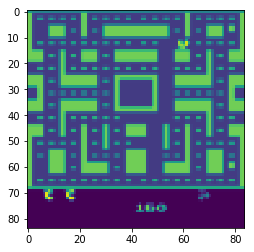

Ended frame 450 with cumulative reward 160.0


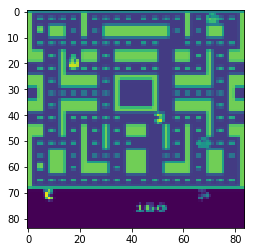

Ended frame 600 with cumulative reward 210.0


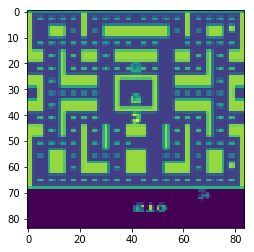

Ended frame 693 with cumulative reward 210.0


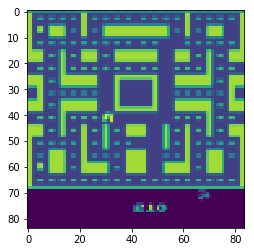

Episode number 33
Ended frame 150 with cumulative reward 70.0


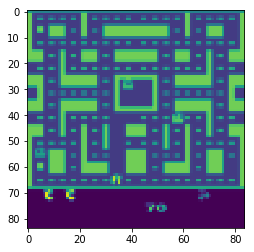

Ended frame 300 with cumulative reward 150.0


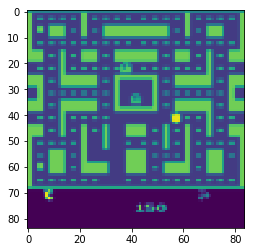

Ended frame 450 with cumulative reward 210.0


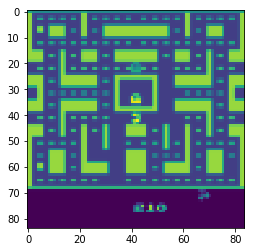

Ended frame 600 with cumulative reward 250.0


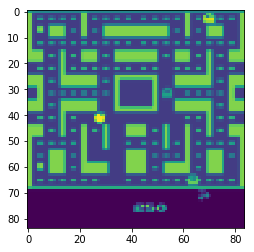

Ended frame 750 with cumulative reward 350.0


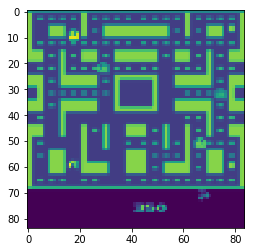

Ended frame 845 with cumulative reward 350.0


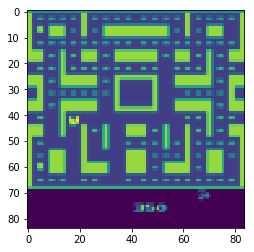

Episode number 34
Ended frame 150 with cumulative reward 100.0


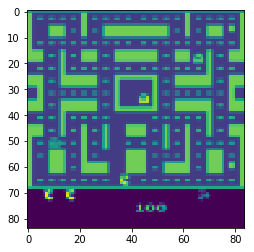

Ended frame 300 with cumulative reward 140.0


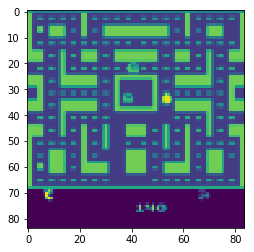

Ended frame 450 with cumulative reward 230.0


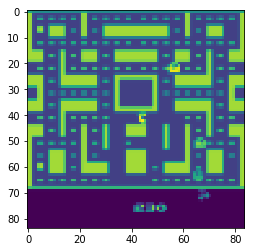

Ended frame 528 with cumulative reward 240.0


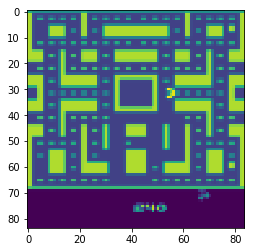

Episode number 35
Ended frame 150 with cumulative reward 50.0


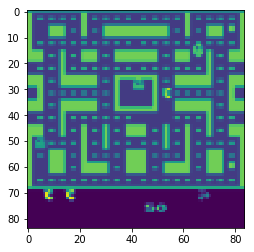

Ended frame 300 with cumulative reward 140.0


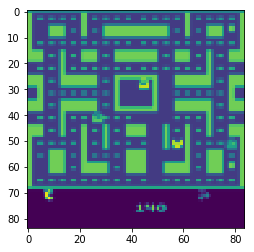

Ended frame 450 with cumulative reward 160.0


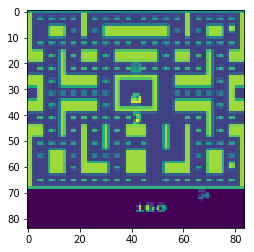

Ended frame 600 with cumulative reward 260.0


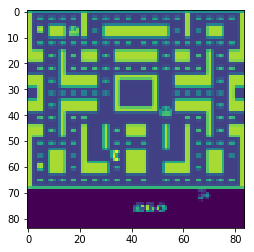

Ended frame 650 with cumulative reward 260.0


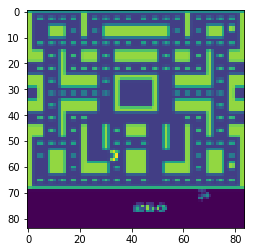

Episode number 36
Ended frame 150 with cumulative reward 40.0


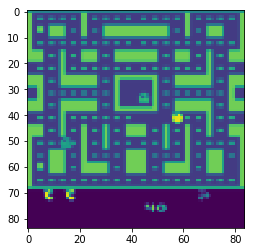

Ended frame 300 with cumulative reward 80.0


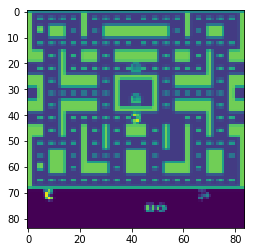

Ended frame 450 with cumulative reward 160.0


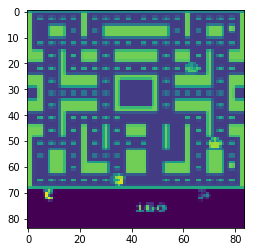

Ended frame 574 with cumulative reward 210.0


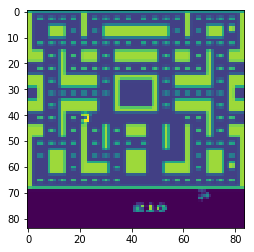

Episode number 37
Ended frame 150 with cumulative reward 70.0


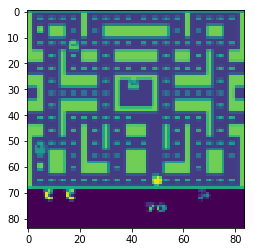

Ended frame 300 with cumulative reward 100.0


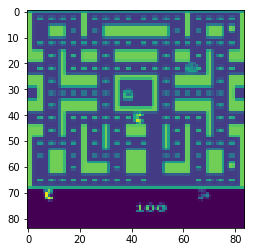

Ended frame 450 with cumulative reward 190.0


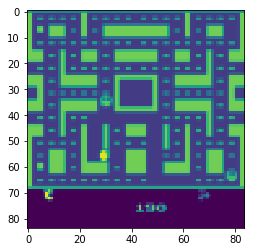

Ended frame 600 with cumulative reward 200.0


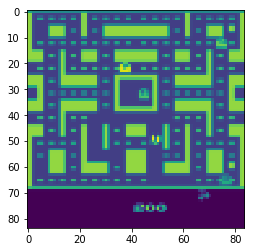

Ended frame 709 with cumulative reward 210.0


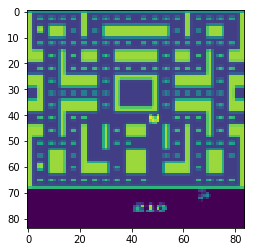

Episode number 38
Ended frame 150 with cumulative reward 90.0


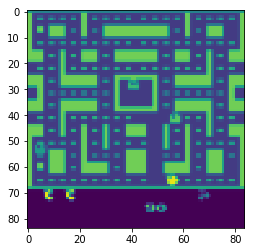

Ended frame 300 with cumulative reward 130.0


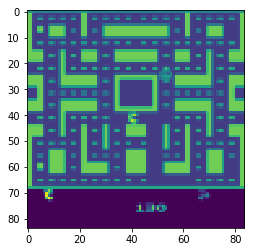

Ended frame 450 with cumulative reward 230.0


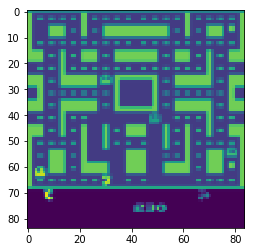

Ended frame 600 with cumulative reward 230.0


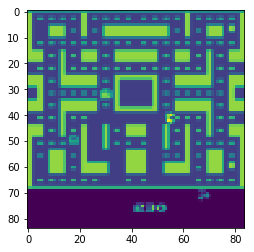

Ended frame 681 with cumulative reward 300.0


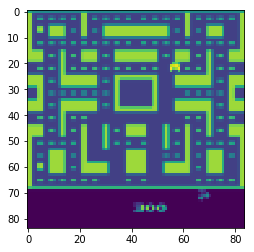

Episode number 39
Ended frame 150 with cumulative reward 80.0


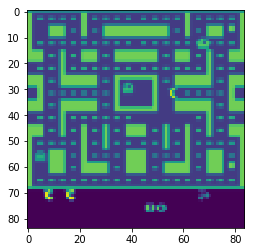

Ended frame 300 with cumulative reward 110.0


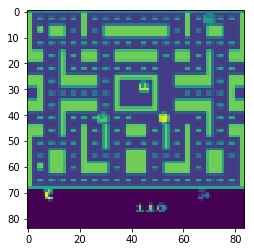

Ended frame 450 with cumulative reward 160.0


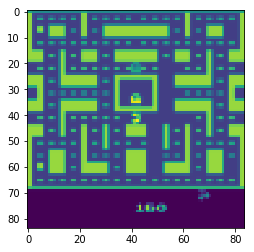

Ended frame 600 with cumulative reward 220.0


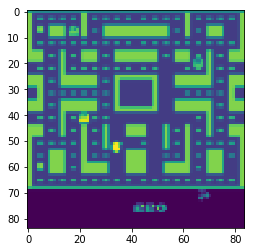

Ended frame 717 with cumulative reward 270.0


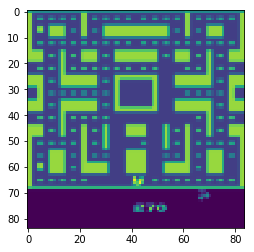

Episode number 40
Ended frame 150 with cumulative reward 30.0


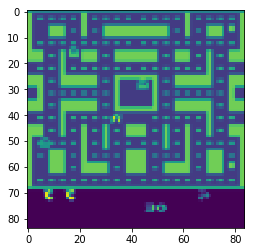

Ended frame 300 with cumulative reward 100.0


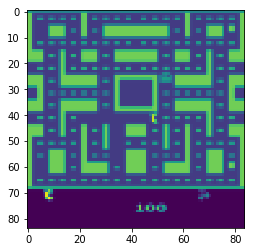

Ended frame 450 with cumulative reward 190.0


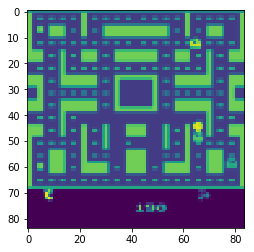

Ended frame 600 with cumulative reward 230.0


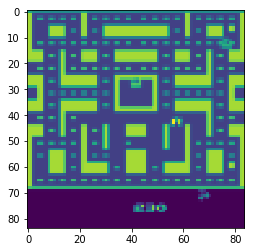

Ended frame 712 with cumulative reward 240.0


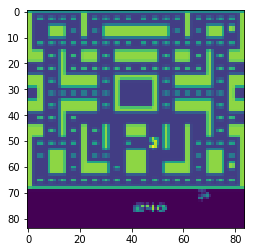

Episode number 41
Ended frame 150 with cumulative reward 70.0


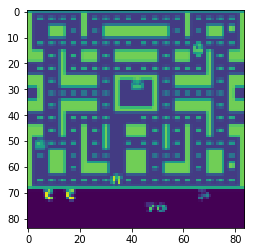

Ended frame 300 with cumulative reward 150.0


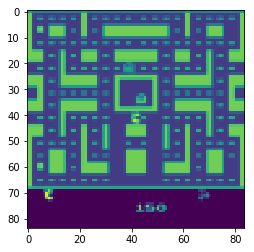

Ended frame 450 with cumulative reward 190.0


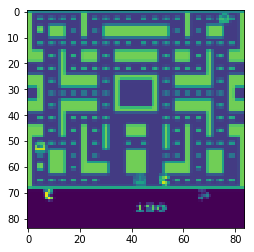

Ended frame 600 with cumulative reward 250.0


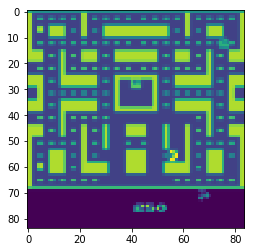

Ended frame 733 with cumulative reward 260.0


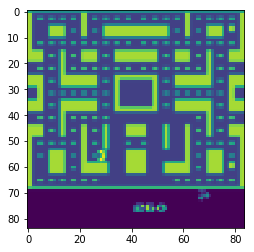

Episode number 42
Ended frame 150 with cumulative reward 30.0


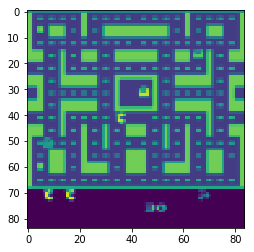

Ended frame 300 with cumulative reward 80.0


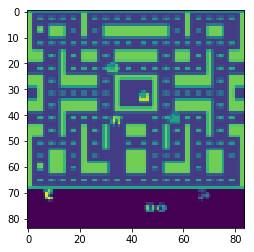

Ended frame 450 with cumulative reward 90.0


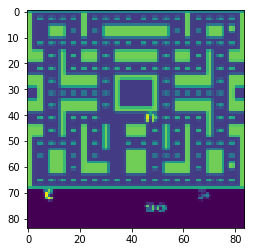

Ended frame 600 with cumulative reward 90.0


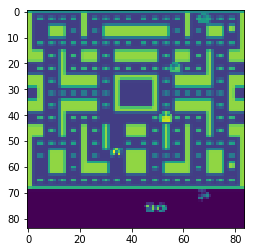

Ended frame 708 with cumulative reward 150.0


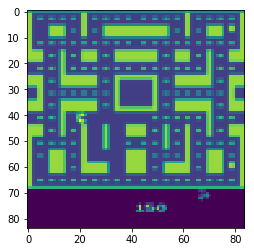

Episode number 43
Ended frame 150 with cumulative reward 20.0


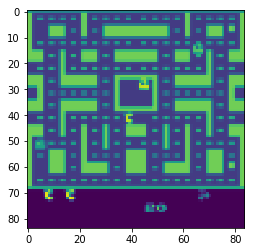

Ended frame 300 with cumulative reward 110.0


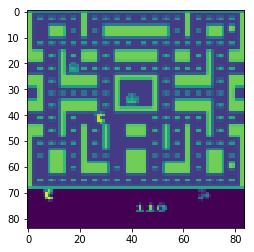

Ended frame 450 with cumulative reward 220.0


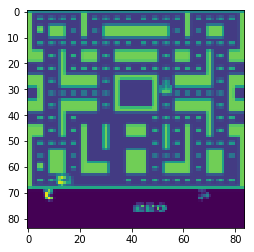

Ended frame 600 with cumulative reward 220.0


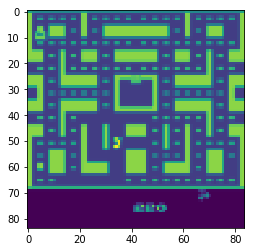

Ended frame 695 with cumulative reward 250.0


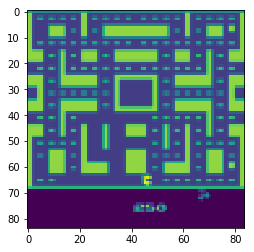

Episode number 44
Ended frame 150 with cumulative reward 40.0


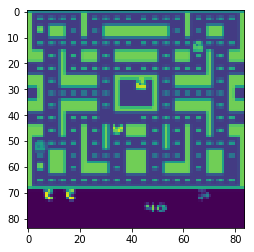

Ended frame 300 with cumulative reward 150.0


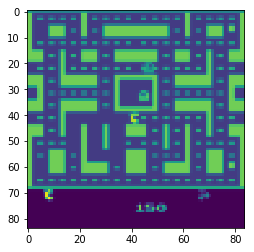

Ended frame 450 with cumulative reward 160.0


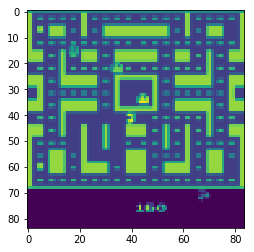

Ended frame 574 with cumulative reward 160.0


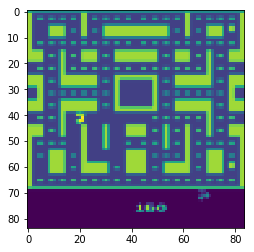

Episode number 45
Ended frame 150 with cumulative reward 40.0


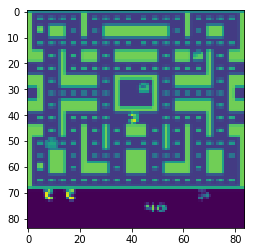

Ended frame 300 with cumulative reward 70.0


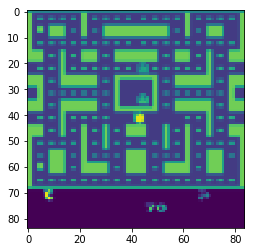

Ended frame 450 with cumulative reward 160.0


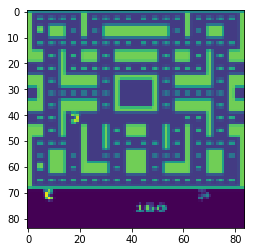

Ended frame 600 with cumulative reward 190.0


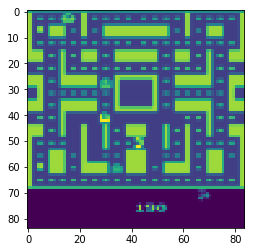

Ended frame 638 with cumulative reward 200.0


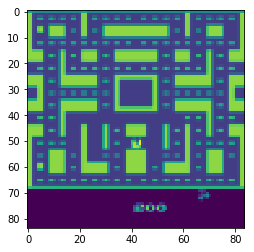

Episode number 46
Ended frame 150 with cumulative reward 30.0


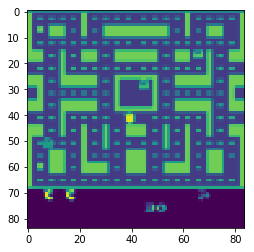

Ended frame 300 with cumulative reward 70.0


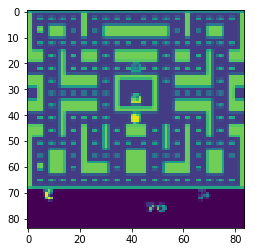

Ended frame 450 with cumulative reward 90.0


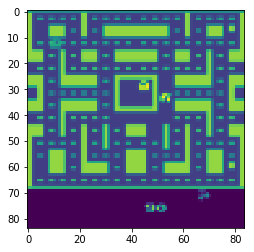

Ended frame 554 with cumulative reward 130.0


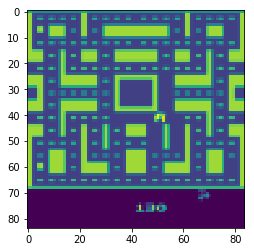

Episode number 47
Ended frame 150 with cumulative reward 90.0


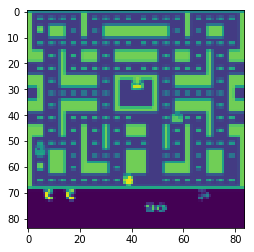

Ended frame 300 with cumulative reward 120.0


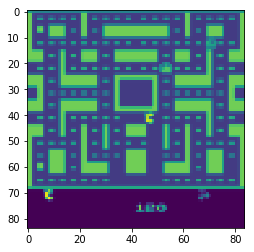

Ended frame 450 with cumulative reward 210.0


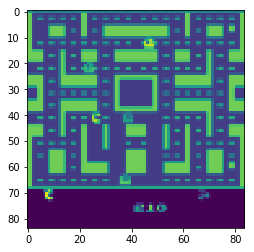

Ended frame 600 with cumulative reward 230.0


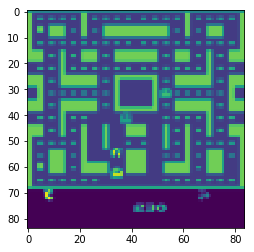

Ended frame 725 with cumulative reward 250.0


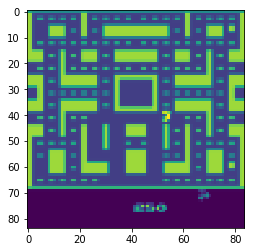

Episode number 48
Ended frame 150 with cumulative reward 50.0


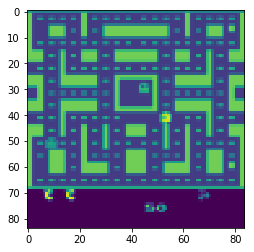

Ended frame 300 with cumulative reward 80.0


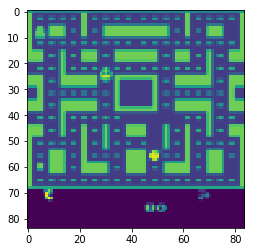

Ended frame 450 with cumulative reward 120.0


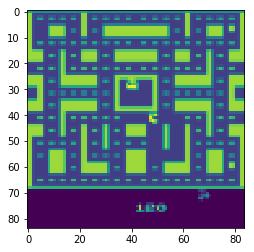

Ended frame 600 with cumulative reward 250.0


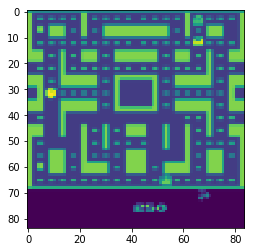

Ended frame 750 with cumulative reward 560.0


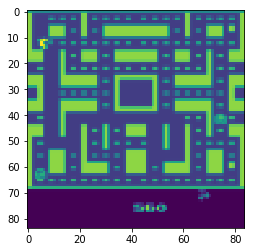

Ended frame 839 with cumulative reward 610.0


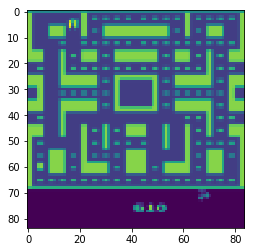

Episode number 49
Ended frame 150 with cumulative reward 60.0


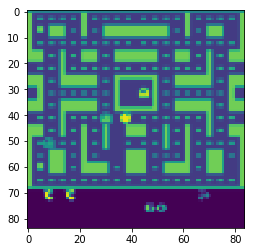

Ended frame 300 with cumulative reward 70.0


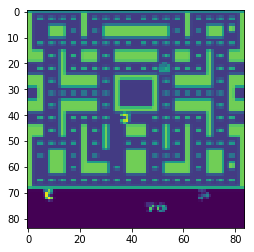

Ended frame 450 with cumulative reward 130.0


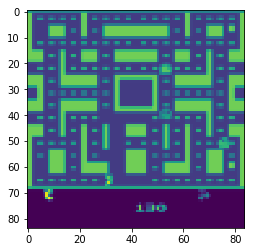

Ended frame 600 with cumulative reward 170.0


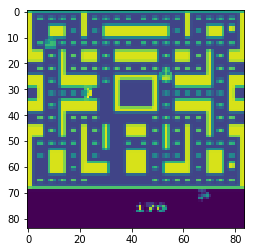

Ended frame 715 with cumulative reward 240.0


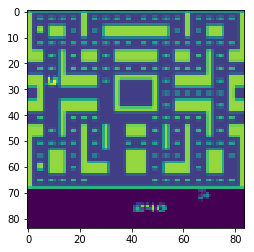

Episode number 50
Ended frame 150 with cumulative reward 20.0


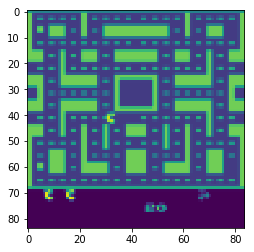

Ended frame 300 with cumulative reward 80.0


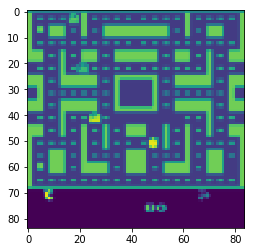

Ended frame 450 with cumulative reward 120.0


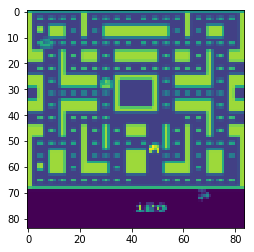

Ended frame 580 with cumulative reward 150.0


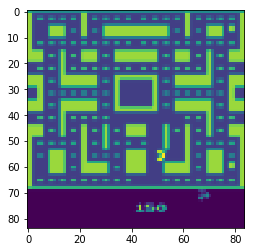

Episode number 51
Ended frame 150 with cumulative reward 30.0


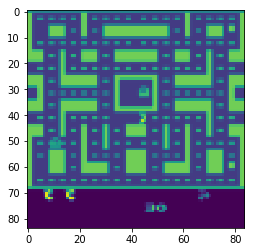

Ended frame 300 with cumulative reward 100.0


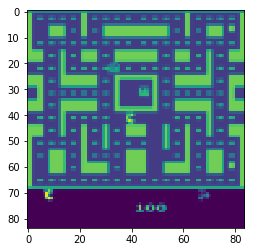

Ended frame 450 with cumulative reward 150.0


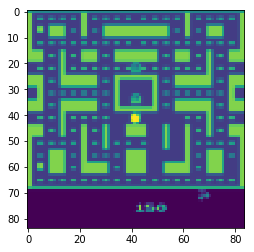

Ended frame 600 with cumulative reward 160.0


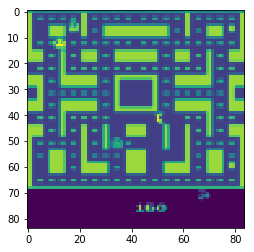

In [0]:
# Episode loop

replay_memory = deque([])
num_frames = 0

for i in range(NUM_EPISODES):
    print("Episode number", i)
    frame_deque = deque([])
    done = False
    num_frames = 0
    cum_reward = 0
    state = None
    new_state = None

    env.reset()
    while not done:
        # Take action and get information from the environment
        if num_frames == 4:
            action = agent.get_action(state)
        else:
            action = env.action_space.sample()

        xt, rt, done, _ = env.step(action)
        xt = preprocess_observation(xt)
        cum_reward += rt

        # Add new frame to frame_deque, to make the 4-frame state
        if len(frame_deque) == 4:
            frame_deque.popleft()
        frame_deque.append(xt)

        # Add to replay_memory
        new_state = get_state(frame_deque)
        if len(replay_memory) == EXPERIENCE_REPLAY_CAPACITY:
            replay_memory.popleft()
        if num_frames > 4:
            replay_memory.append((state, action, rt, done, new_state))

        state = new_state

        # Learn from replay_memory
        if len(replay_memory) >= MINIBATCH_SIZE:
            agent.train(replay_memory)

        # Debugging information
        num_frames += 1
        if num_frames % 150 == 0 or done:
            print("Ended frame", num_frames, "with cumulative reward",
                  cum_reward, flush=True)
            plt.imshow(xt)
            plt.show()

    # Update target network after each episode
    agent.update_target_network()

    if i % 5 == 0:
        # Save model to disk
        path = F"/content/gdrive/My Drive/MsPacmanDQN.pkl" 
        torch.save(agent.target_dqn.state_dict(), path)

In [0]:
torch.save(agent.target_dqn.state_dict(), MODEL_SAVE_PATH)